# Learning to Pivot - Jets
In this example we'll reimplement the jets example from Learning to Pivot [Louppe, Kagan, & Cranmer, 2016](https://papers.nips.cc/paper/2017/hash/48ab2f9b45957ab574cf005eb8a76760-Abstract.html), as per the official code repo (https://github.com/glouppe/paper-learning-to-pivot).

In this signal inferrence example, the data contains both jets from the hard process and from pile-up. We ideally want our classifier to perform equally well on both nominal jets and pile-up. This achieved through the use of an adversarial training configuration, in which a second model tries to determine whether a jet originated from pile-up based entirely on the prediction of the main signal/background classifier.

The examples assumes some familiarity with LUMIN, so you may wish to check out other examples before this one, e.g. Simple_Binary_Classification_of_earnings.ipynb, and that you are familiar with the paper method.

Run the cell below to download the data

In [1]:
# !mkdir data
# !wget http://www.igb.uci.edu/~pfbaldi/physics/data/hepjets/highlevel/test_no_pile_5000000.h5 -O data/jets_no_pile_test.h5
# !wget http://www.igb.uci.edu/~pfbaldi/physics/data/hepjets/highlevel/test_pile_5000000.h5 -O data/jets_pile_test.h5

If running in Google Collab, uncomment and run the cell below to install LUMIN

In [2]:
# !pip install lumin

--> **RESTART INSTANCE TO ENSURE PDPBOX IS FOUND** <--

In [3]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [4]:
from fastcore.all import store_attr, is_listy, Path, is_close, partialler
import numpy as np
from typing import *
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import timeit
import inspect

from sklearn.model_selection import train_test_split 

import torch
from torch import nn, Tensor

from lumin.nn.callbacks.callback import Callback
from lumin.nn.models.model_builder import ModelBuilder
from lumin.utils.misc import ids2unique
from lumin.utils.data import check_val_set
from lumin.data_processing.pre_proc import fit_input_pipe
from lumin.data_processing.file_proc import df2foldfile
from lumin.nn.models.model_builder import ModelBuilder
from lumin.nn.models.model import Model
from lumin.nn.models.helpers import CatEmbedder
from lumin.nn.data.fold_yielder import FoldYielder
from lumin.nn.metrics.class_eval import RocAucScore
from lumin.nn.training.train import train_models
from lumin.plotting.plot_settings import PlotSettings

/home/giles/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Data processing

First we'll import and process the data, combing the nominal and pile-up data into a single dataset. We follow the official code repo in terms of dataset sizes.

In [5]:
PATH = Path('data')

In [6]:
df = None
for f in ['jets_no_pile_test','jets_pile_test']:
    h5 = h5py.File(PATH/f'{f}.h5', 'r')
    x = h5['features'][()]
    cont_feats = [f'feat_{i}' for i in range(x.shape[1])]
    tmp_df = pd.DataFrame(x, columns=cont_feats)
    tmp_df['gen_target'] = h5["targets"][()]
    tmp_df['gen_is_pile'] = 0 if 'no_pile' in f else 1
    tmp_df['gen_strat'] = ids2unique(tmp_df[['gen_target','gen_is_pile']].values)
    if df is None: df = tmp_df
    else:          df = df.append(tmp_df, ignore_index=True)
df

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,gen_target,gen_is_pile,gen_strat
0,83.226501,0.127185,0.044609,1.17021,0.926321,0.262131,1.0,0,2.0
1,17.167601,0.054163,0.012444,2.23471,4.203240,0.308841,0.0,0,1.0
2,52.909901,0.130029,0.032617,1.24991,1.077190,0.432114,0.0,0,1.0
3,22.979900,0.070247,0.014154,3.12134,2.636900,0.392884,0.0,0,1.0
4,36.210098,0.107847,0.029352,1.61934,2.087450,0.554356,0.0,0,1.0
...,...,...,...,...,...,...,...,...,...
9999995,85.821602,0.124378,0.039516,1.00741,0.826471,0.281355,1.0,1,6.0
9999996,120.991997,0.357036,0.335816,1.65357,2.365450,0.487707,1.0,1,6.0
9999997,145.895004,0.201805,0.102891,1.13028,0.803343,0.262889,1.0,1,6.0
9999998,89.709602,0.170860,0.060632,1.45797,1.152210,0.461681,0.0,1,3.0


In [7]:
train_df, test_df = train_test_split(df, test_size=25000, random_state=1, stratify=df.gen_strat)

In [8]:
train_df = train_df[:150000]

In [9]:
input_pipe = fit_input_pipe(train_df, cont_feats=cont_feats, savename=PATH/'input_pipe')

In [10]:
train_df[cont_feats] = input_pipe.transform(train_df[cont_feats])
test_df[cont_feats] = input_pipe.transform(test_df[cont_feats])

In [11]:
assert is_close(train_df[cont_feats].mean(),0)

In [12]:
check_val_set(train_df[cont_feats], test_df[cont_feats])


AUC for train-validation discrimination = 0.49765137357788825
Top 10 most important features are:
   index Feature  Importance
0      0  feat_4    0.002093
1      1  feat_3    0.001744
2      2  feat_5   -0.001977
3      3  feat_2   -0.002326
4      4  feat_1   -0.004186
5      5  feat_0   -0.006395


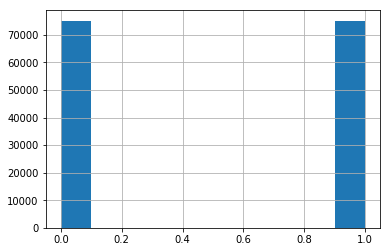

In [13]:
train_df.gen_target.hist()

Note that we include an extra column in the foldfile with the 'gen_is_pile' feature. We'll use this as the target when conditioning the adversary.

In [14]:
df2foldfile(df=train_df, n_folds=10,
            cont_feats=cont_feats, cat_feats=[], targ_feats='gen_target', misc_feats=['gen_is_pile'],
            savename=PATH/'train', targ_type='int', strat_key='gen_strat')

Saving fold 0 with 15000 events
Saving fold 1 with 15000 events
Saving fold 2 with 15000 events
Saving fold 3 with 15000 events
Saving fold 4 with 15000 events
Saving fold 5 with 15000 events
Saving fold 6 with 15000 events
Saving fold 7 with 15000 events
Saving fold 8 with 15000 events
Saving fold 9 with 15000 events


In [15]:
df2foldfile(df=test_df, n_folds=10,
            cont_feats=cont_feats, cat_feats=[], targ_feats='gen_target', misc_feats=['gen_is_pile'],
            savename=PATH/'test', targ_type='int', strat_key='gen_strat')

Saving fold 0 with 2500 events
Saving fold 1 with 2500 events
Saving fold 2 with 2500 events
Saving fold 3 with 2500 events
Saving fold 4 with 2500 events
Saving fold 5 with 2500 events
Saving fold 6 with 2500 events
Saving fold 7 with 2500 events
Saving fold 8 with 2500 events
Saving fold 9 with 2500 events


In [16]:
train_fy = FoldYielder(PATH/'train.hdf5'); train_fy

FoldYielder with 10 folds, containing ['gen_is_pile', 'inputs', 'targets']

## Baseline 0
As a first baseline, let's train a classifier only on the nominal data and ignore the pile-up. We'll use the same model as the paper (minus the tanh initial activation function)

In [17]:
bs = 128
objective = 'classification'
model_args = {'body':{'width':64, 'depth':3}}
opt_args = {'opt':'sgd', 'lr':2e-3}

model_builder = ModelBuilder(objective, cont_feats=train_fy.cont_feats, n_out=1, model_args=model_args, opt_args=opt_args)
Model(model_builder)

Inputs:
6 Continuous: ['feat_0', 'feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5']
                   
0  Categorical: []
                   
0  Matrix elements: []
                   

Model:
<bound method Module.parameters of Sequential(
  (0): CatEmbHead()
  (1): FullyConnected(
    (layers): Sequential(
      (0): Sequential(
        (0): Linear(in_features=6, out_features=64, bias=True)
        (1): ReLU()
      )
      (1): Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): ReLU()
      )
      (2): Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): ReLU()
      )
    )
  )
  (2): ClassRegMulti(
    (dense): Linear(in_features=64, out_features=1, bias=True)
    (act): Sigmoid()
  )
)>
                   

Number of trainable parameters: 8833
                   

Optimiser:
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.002
    momentum: 0
    nesterov: False
    weight_decay: 0
)
                   



Since our data contains pile-up data we want to write a callback to cut out the pile-up data during training to get our baseline

In [18]:
class DataMask(Callback):
    def on_fold_begin(self) -> None:
        r'''
        Whenever new fold is loaded into a BatchYielder, load the is_pile data and remove data corresponding to pile-up events.
        Since bulk_move=True caches validation data, we only want to remove the pile-up once.
        '''
        
        idx = self.model.fit_params.trn_idx if self.model.fit_params.state == 'train' else self.model.fit_params.val_idx
        is_pu = self.model.fit_params.fy.get_column('gen_is_pile', n_folds=1, fold_idx=idx)
        m = is_pu == 0
        try:
            self.model.fit_params.by.inputs = self.model.fit_params.by.inputs[m]
            if self.model.fit_params.by.weights is not None: self.model.fit_params.by.weights = self.model.fit_params.by.weights[m]        
            if self.model.fit_params.by.targets is not None: self.model.fit_params.by.targets = self.model.fit_params.by.targets[m]
        except IndexError:
            if self.model.fit_params.state == 'train': print(sys.exc_info()); assert False  # Errors expected for validation with bulk_move=True due to caching of validation data

In [19]:
n_models = 1
patience = 5
n_epochs = 50

cb_partials = [partialler(DataMask)]
metric_partials = [partialler(RocAucScore, main_metric=False)]

Training model 1 / 1, Val ID = 0


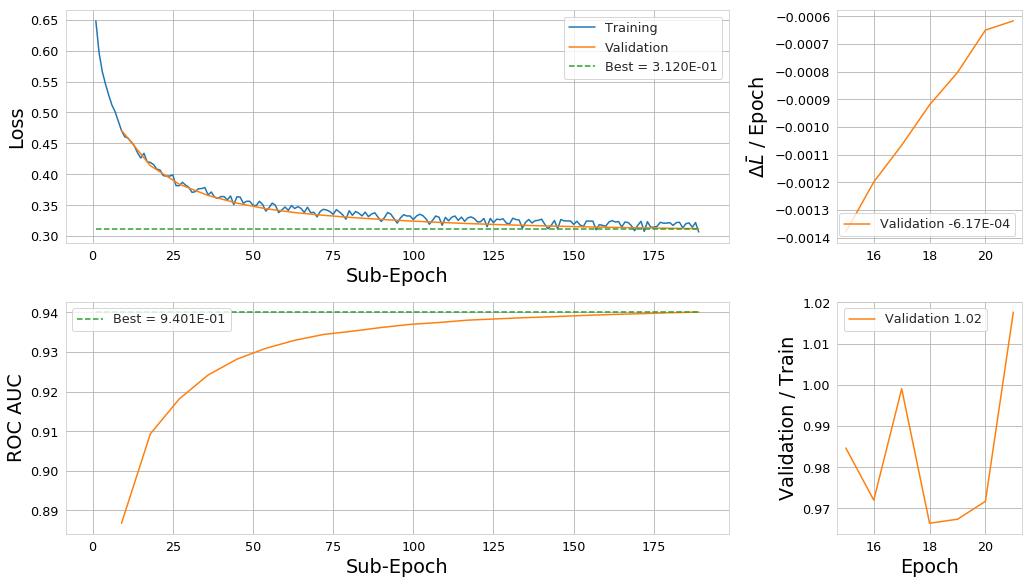

Model took 31.150s

Scores are: {'loss': 0.3120052218437195, 'ROC AUC': 0.9400910295495924}

______________________________________
Training finished
Cross-validation took 31.211s 


<Figure size 1024x576 with 0 Axes>

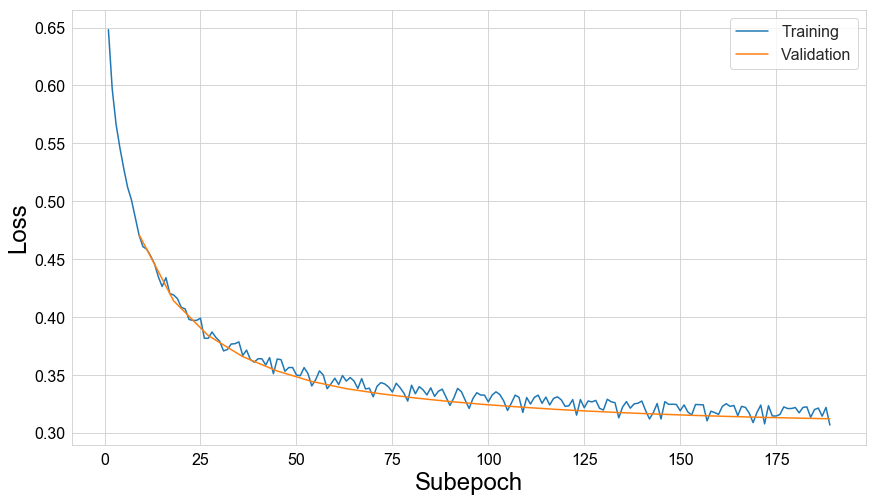

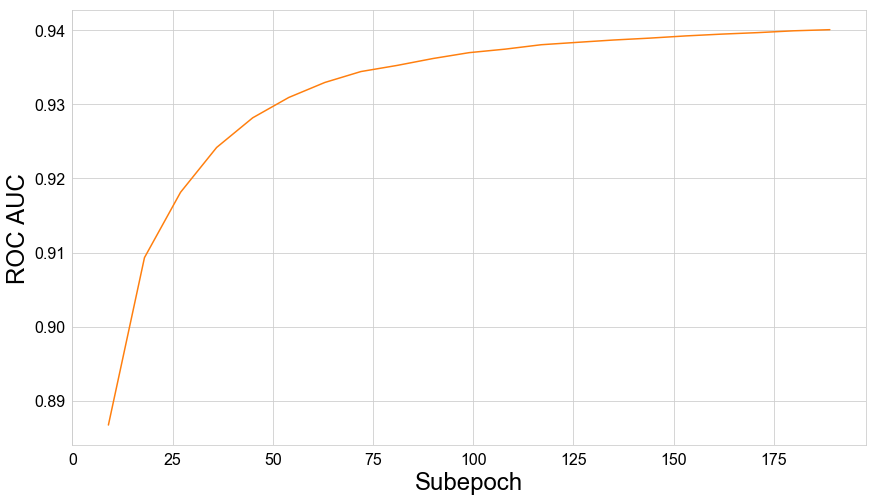

Mean loss = 0.3120052218437195±0.0
Mean ROC AUC = 0.9400910295495924±0.0
______________________________________



In [20]:
results_no_pu, _, _ = train_models(train_fy,  # Training data
                                   n_models,  # Number of models to train
                                   model_builder=model_builder,  # How to build models, losses, and optimisers
                                   bs=bs,  # Batch size
                                   cb_partials=cb_partials,
                                   metric_partials=metric_partials,  # Pass our evaluation metrics
                                   save_best=False,  # Use model at end of training
                                   n_epochs=21,  # Maximum number of epochs to train
                                   patience=None,  # If not None, stop training if validation loss doesn't improve after set number of cycles
                                   savepath='no_PU')

We'll cache our models in a dictionary to use later

In [21]:
models = {}

In [22]:
models['baseline_np_PU'] = Model.from_save(results_no_pu[0]['path']/'train_0.h5', model_builder)

## Baseline 1
As a second baseline, let's see what happens when we train the classifier on both nominal and pile-up data. To do this we remove the data-masking callback we were using.

Training model 1 / 1, Val ID = 0


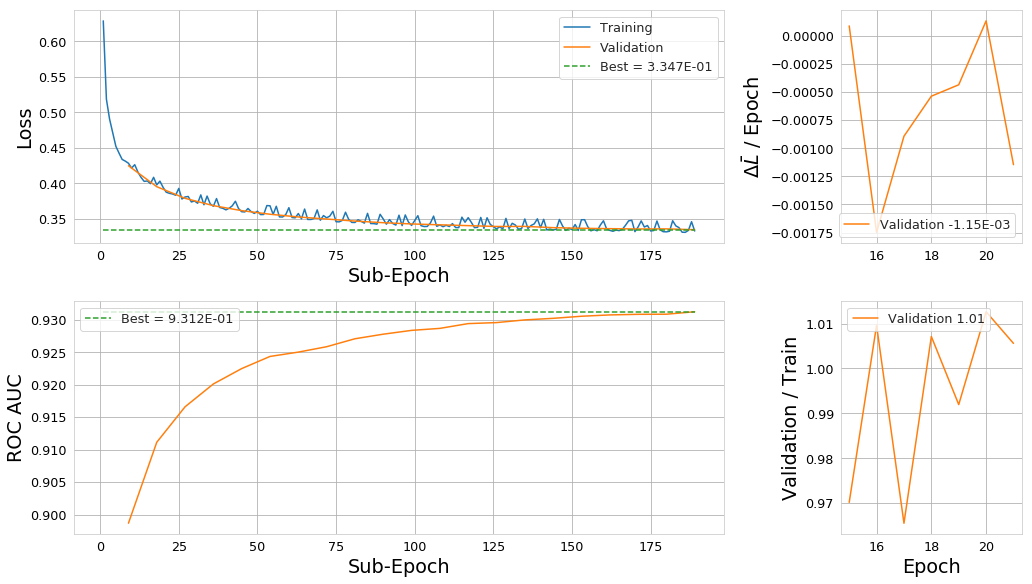

Model took 42.766s

Scores are: {'loss': 0.33467668294906616, 'ROC AUC': 0.9312175889026226}

______________________________________
Training finished
Cross-validation took 42.824s 


<Figure size 1024x576 with 0 Axes>

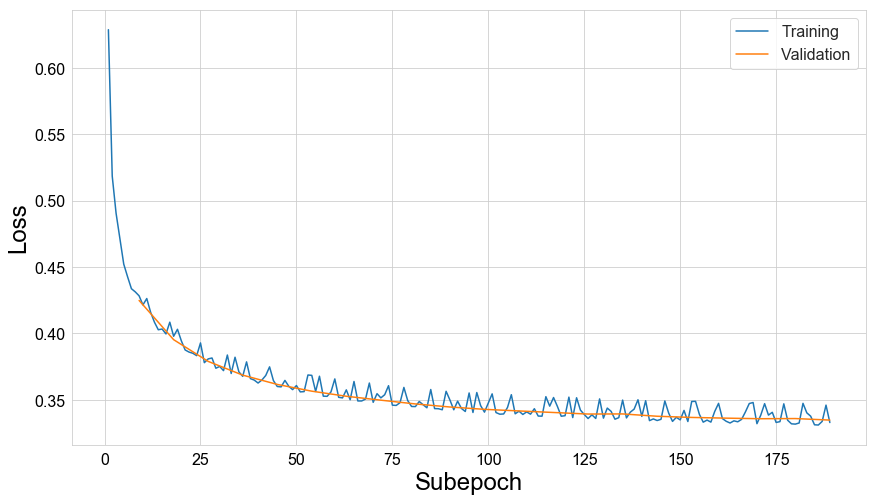

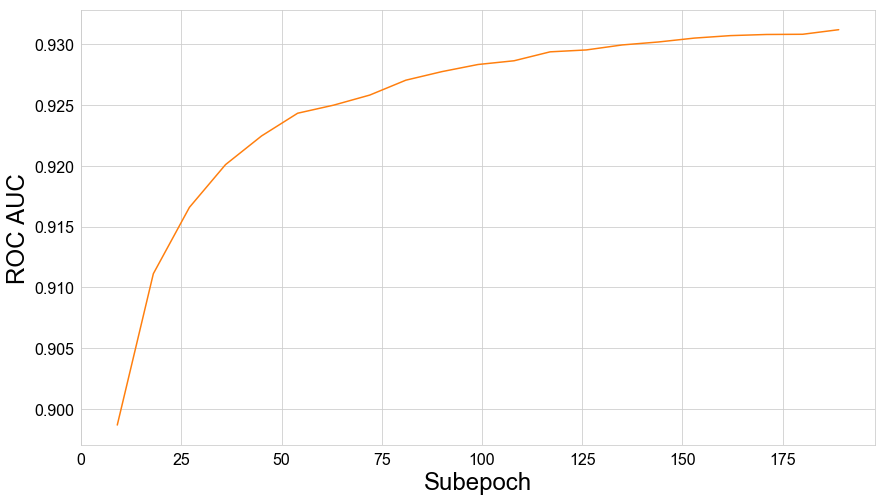

Mean loss = 0.33467668294906616±0.0
Mean ROC AUC = 0.9312175889026226±0.0
______________________________________



In [23]:
results_with_pu, _, _ = train_models(train_fy,  # Training data
                                   n_models,  # Number of models to train
                                   model_builder=model_builder,  # How to build models, losses, and optimisers
                                   bs=bs,  # Batch size
                                   metric_partials=metric_partials,  # Pass our evaluation metrics
                                   save_best=False,  # Use model at end of training
                                   n_epochs=21,  # Maximum number of epochs to train
                                   patience=None,  # If not None, stop training if validation loss doesn't improve after set number of cycles
                                   savepath='with_PU')

We'll cache our models in a dictionary to use later

In [24]:
models['baseline_with_PU'] = Model.from_save(results_with_pu[0]['path']/'train_0.h5', model_builder)

## Adversarial pivot training
Now we'll try training with the adversary present. Usually this would require rewriting the training loop to accommodate swapping between training of the two models. LUMIN, however, includes an implementation called `PivotTraining` where the adversarial is handled in a callback, which takes care of refining the adversary and pretraining of both the main model and the adversary, allowing us to use the existing training loop.

The main model is trying to predict whether data points are signal or background based on the 6 input features. The adversary is trying to predict whether the data points are pile-up or not based only on the prediction of the main model. If the adversary is unable to predict well, then the main model receives a bonus to its loss $L = L_{BCE}-L_{Adv}$, i.e. the main model is encouraged to find a configuration in which it gives accurate predictions for both nominal and pile-up data, and the adversary can do no better than randomly guess.

One subtlety is that the authors only condition (pretrain and refine) the adversary on background data, so we want anther masking callback to remove signal data when conditioning the adversary.

In [25]:
class BkgMask(Callback):
    def on_fold_begin(self) -> None:
        r'''
        Whenever new fold is loaded into a BatchYielder, load the class data and remove data corresponding to signal events.
        Since bulk_move=True caches validation data, we only want to remove the pile-up once.
        '''
        
        idx = self.model.fit_params.trn_idx if self.model.fit_params.state == 'train' else self.model.fit_params.val_idx
        targs = self.model.fit_params.fy.get_column('targets', n_folds=1, fold_idx=idx)
        m = targs == 0
        try:
            self.model.fit_params.by.inputs = self.model.fit_params.by.inputs[m]
            if self.model.fit_params.by.weights is not None: self.model.fit_params.by.weights = self.model.fit_params.by.weights[m]        
            if self.model.fit_params.by.targets is not None: self.model.fit_params.by.targets = self.model.fit_params.by.targets[m]
        except IndexError:
            if self.model.fit_params.state == 'train': print(sys.exc_info()); assert False  # Errors expected for validation with bulk_move=True due to caching of validation data

We need to define the model for the adversary. Our classifier outputs a single prediction, so our adversary should only expect one input. 

In [26]:
adv_model_builder = ModelBuilder(objective, cont_feats=['disc_pred'], n_out=1, model_args=model_args, opt_args=opt_args)
Model(adv_model_builder)

Inputs:
1 Continuous: ['disc_pred']
                   
0  Categorical: []
                   
0  Matrix elements: []
                   

Model:
<bound method Module.parameters of Sequential(
  (0): CatEmbHead()
  (1): FullyConnected(
    (layers): Sequential(
      (0): Sequential(
        (0): Linear(in_features=1, out_features=64, bias=True)
        (1): ReLU()
      )
      (1): Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): ReLU()
      )
      (2): Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): ReLU()
      )
    )
  )
  (2): ClassRegMulti(
    (dense): Linear(in_features=64, out_features=1, bias=True)
    (act): Sigmoid()
  )
)>
                   

Number of trainable parameters: 8513
                   

Optimiser:
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.002
    momentum: 0
    nesterov: False
    weight_decay: 0
)
                   

Loss:
<class 'torch.nn.modules.loss.BCELoss'>

##### lambda = 10

In [27]:
from lumin.nn.callbacks.adversarial_callbacks import PivotTraining

In [28]:
?? PivotTraining

The pivot trainer has a range of different arguments to influence the training. The authors find that a lambda coefficient of 10 is best, refine their adversary once for every batch of main-model training (this takes about 14 minutes and doesn't show progress to the user (currently)).
They also train their main model for the equivalent of a single epoch, and pretrain both the main model and the adversary for 20 epochs. Note that we pass the background mask to both the pretaining and training callbacks for the adversary.

In [29]:
cb_partials = [partialler(PivotTraining, n_pretrain_main=20, n_pretrain_adv=20, adv_coef=10, adv_model_builder=adv_model_builder, adv_targets=['gen_is_pile'], adv_update_freq=1, adv_update_on='batch',
               adv_pretrain_cb_partials=[BkgMask], adv_train_cb_partials=[BkgMask])]

Training model 1 / 1, Val ID = 0
Pretraining main model


pretraining main model took 25.434s

Pretraining adversary


pretraining adversary took 15.529s



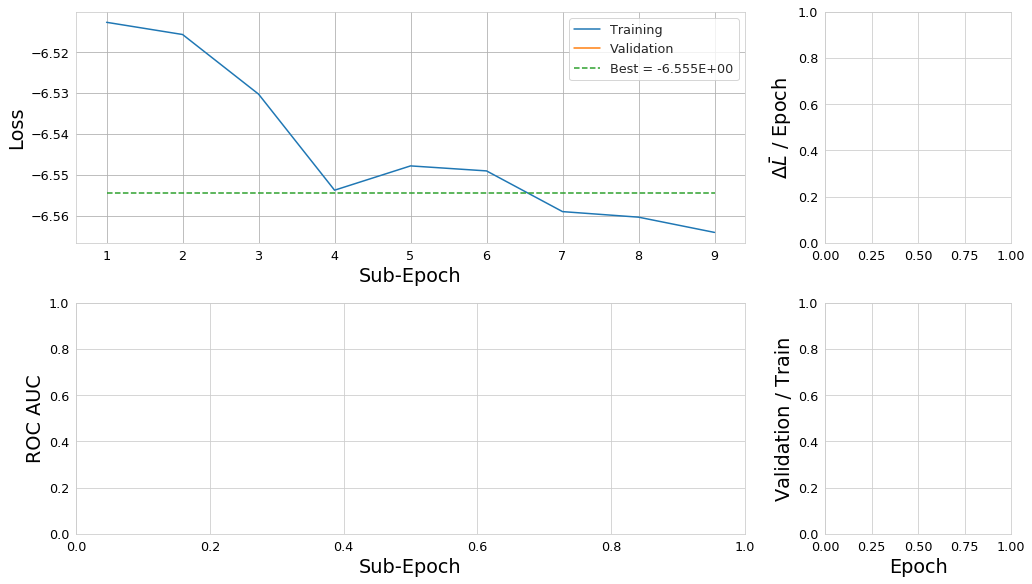

Model took 930.540s

Scores are: {'loss': -6.554547309875488, 'ROC AUC': 0.9159732408796037}

______________________________________
Training finished
Cross-validation took 930.594s 


<Figure size 1024x576 with 0 Axes>

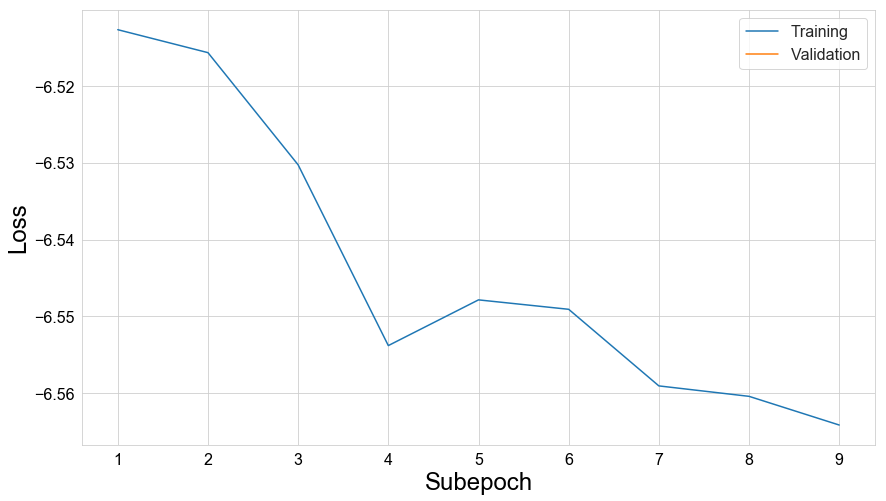

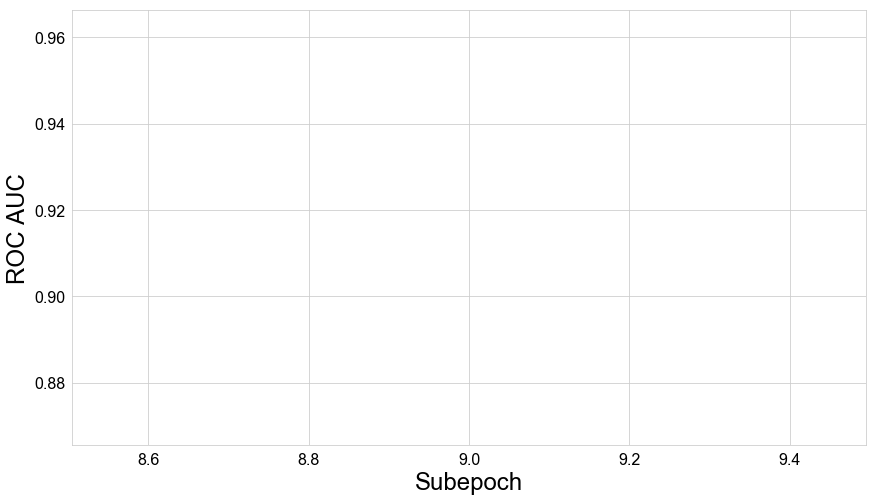

Mean loss = -6.554547309875488±0.0
Mean ROC AUC = 0.9159732408796037±0.0
______________________________________



In [30]:
results, histories, cycle_losses = train_models(train_fy,  # Training data
                                                n_models,  # Number of models to train
                                                model_builder=model_builder,  # How to build models, losses, and optimisers
                                                bs=bs,  # Batch size
                                                cb_partials=cb_partials,  # List of uninitialised callbacks
                                                metric_partials=metric_partials,  # Pass our evaluation metrics
                                                save_best=False,  # Use model at end of training
                                                n_epochs=1,  # Maximum number of epochs to train
                                                patience=None,  # If not None, stop training if validation loss doesn't improve after set number of cycles (automatic save best)
                                                savepath='advbatch10')

In [31]:
models['pivot_10_batch'] = Model.from_save(results[0]['path']/'train_0.h5', model_builder)

### Results

Now let's load up our testing dataset and compare model performance

In [32]:
test_fy = FoldYielder(PATH/'test.hdf5')
test_df = test_fy.get_df(inc_inputs=True)
test_df['gen_is_pile'] = test_fy.get_column('gen_is_pile')

25000 datapoints loaded


In [33]:
for m in models:
    test_df[f'{m}_pred'] = models[m].predict(test_df[test_fy.cont_feats].values)

In [34]:
test_df

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,gen_target,gen_is_pile,baseline_np_PU_pred,baseline_with_PU_pred,pivot_10_batch_pred
0,0.723891,1.156962,1.066613,-0.096962,-0.023889,0.093575,1,1,0.554652,0.694814,0.837682
1,-0.953140,-0.582820,-0.526646,-0.155149,-0.126728,0.485823,0,0,0.084144,0.053592,0.115935
2,-0.308607,0.684969,0.701307,0.118780,0.371001,0.302801,0,1,0.340414,0.230434,0.310290
3,0.033454,0.394483,-0.409080,0.224354,-0.309268,-0.541908,0,1,0.430740,0.147321,0.215743
4,-0.033929,0.331212,-0.073289,-0.047259,-0.056341,2.097643,0,1,0.448887,0.496074,0.396464
...,...,...,...,...,...,...,...,...,...,...,...
24995,1.366622,1.016945,0.659469,-0.166598,-0.113695,0.811795,0,1,0.454976,0.782602,0.675559
24996,0.448999,-0.193008,-0.447522,-0.150334,-0.310933,-0.405349,1,1,0.782851,0.872021,0.844607
24997,0.636709,0.513114,-0.009870,-0.216851,-0.221274,0.632077,1,1,0.638891,0.796547,0.635076
24998,-1.410796,-0.850026,-0.553491,0.470377,0.601009,-0.169287,0,0,0.019403,0.029163,0.090748


Below we see that the pivot approach sacrifices a bit of classification power, however we will compare final performance in terms of the approximate median significance of the signal.

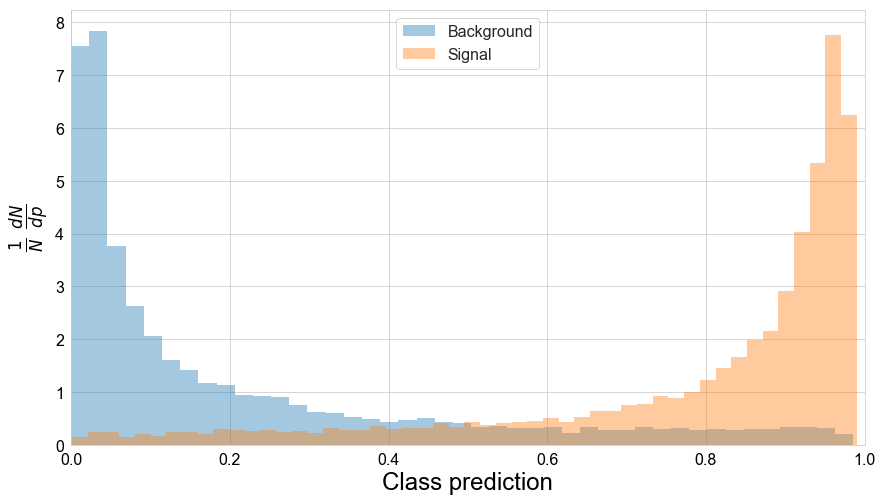

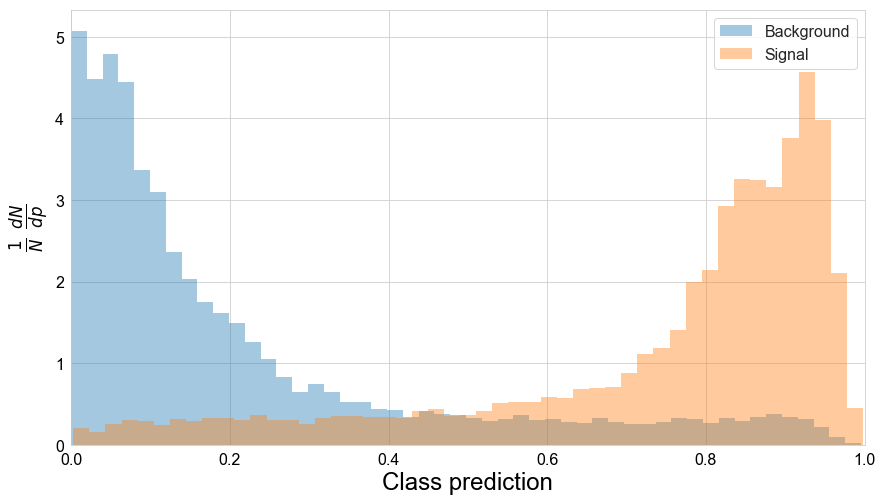

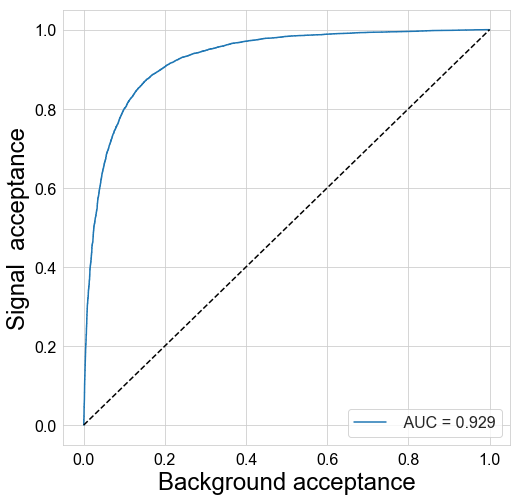

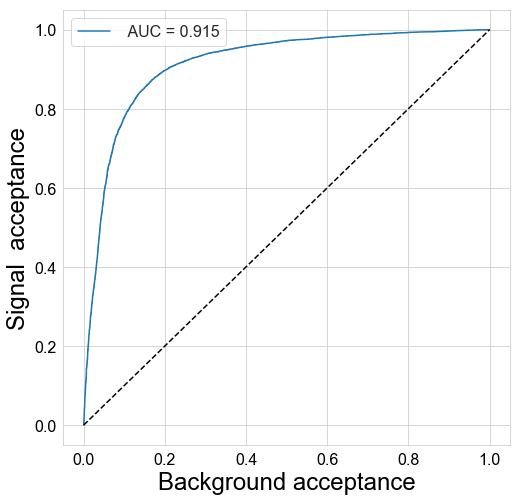

{'': 0.9145484128}

In [35]:
from lumin.plotting.results import plot_binary_class_pred, plot_roc

plot_binary_class_pred(test_df, pred_name='baseline_with_PU_pred')
plot_binary_class_pred(test_df, pred_name='pivot_10_batch_pred')
plot_roc(test_df, pred_name='baseline_with_PU_pred')
plot_roc(test_df, pred_name='pivot_10_batch_pred')

In [36]:
def plot_ams(df:pd.DataFrame, models:List[str], cuts:np.ndarray=np.linspace(0.0, 1.0, 50), settings=PlotSettings()):
    '''Adapted from https://github.com/glouppe/paper-learning-to-pivot/blob/master/code/Jets.ipynb'''
    x00 = (df.gen_target == 0) & (df.gen_is_pile == 0)
    x01 = (df.gen_target == 0) & (df.gen_is_pile == 1)
    x10 = (df.gen_target == 1) & (df.gen_is_pile == 0)
    
    with sns.axes_style(**settings.style), sns.color_palette(settings.cat_palette):
        plt.figure(figsize=(settings.w_mid, settings.h_mid))
        for m in models:
            ams = []
            for c in cuts:
                p_df = (df[f'{m}_pred'] > c)
                ns  = (100/x10.sum()) *len(df[x10 & p_df])
                nb  = (1000/x00.sum())*len(df[x00 & p_df])
                nb1 = (1000/x01.sum())*len(df[x01 & p_df])
                sig_b = 1.0*np.abs(nb-nb1) 

                b0 = 0.5 * (nb - sig_b ** 2 + ((nb - sig_b ** 2) ** 2 + 4 * (ns + nb) * (sig_b ** 2)) ** 0.5)
                ams.append((2.0 * ((ns + nb) * np.log((ns + nb) / b0) - ns - nb + b0) + ((nb - b0) / sig_b) ** 2) ** 0.5)
            plt.plot(cuts, ams, label=m)
        plt.legend(loc=settings.leg_loc, fontsize=settings.leg_sz)
        plt.ylabel("AMS", fontsize=settings.lbl_sz, color=settings.lbl_col)
        plt.xlabel("Threshold on $f(X)$", fontsize=settings.lbl_sz, color=settings.lbl_col)
        plt.xticks(fontsize=settings.tk_sz, color=settings.tk_col)
        plt.yticks(fontsize=settings.tk_sz, color=settings.tk_col)
        plt.show()

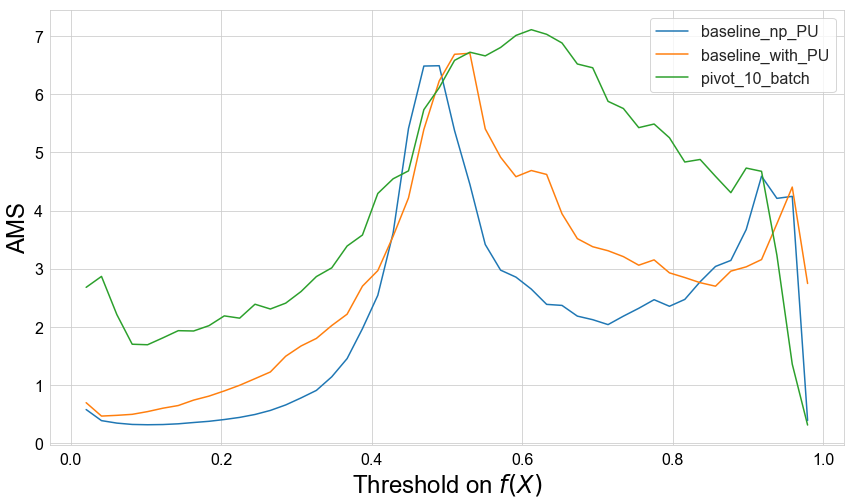

In [37]:
plot_ams(test_df, models.keys())

From this we see that the AMS reaches a higher maximum value with the pivot training, and the optimal cut on the prediction is smoother, meaning that it easier to pick a cut that generalises to new data.